In [1]:
!pip install biopython pandas numpy matplotlib seaborn scipy regex scikit-learn -q

In [12]:
import requests

url = "https://api.genome.ucsc.edu/getData/sequence?genome=hg38;chrom=chr6;start=29585000;end=29605000"

response = requests.get(url)

with open("test_region.fa", "w") as f:
    f.write(response.text)

print("Genome region saved as test_region.fa")


Genome region saved as test_region.fa


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.Seq import Seq
import seaborn as sns
import json
from collections import defaultdict
import regex as re

In [14]:


class ERVHunter:
    def __init__(self):
        self.erv_patterns = {
            'LTR': {
                'pattern': r'TG[ATCG]{40,80}CA',
                'min_length': 300,
                'max_length': 1200
            },
            'PBS': {
                'patterns': [
                    r'TT[ATCG]{18}GG',
                    r'GG[ATCG]{16}CC',
                    r'AA[ATCG]{20}TT'
                ]
            },
            'PPT': {
                'pattern': r'[ATCG]{8,12}GGGG[ATCG]{8,12}'
            }
        }

        self.genome_data = None
        self.chromosome = None
        self.start_pos = None
        self.end_pos = None



    def load_genome_from_file(self, json_file="test_region.fa"):
        """
        Load genome sequence from UCSC JSON file
        """

        # Read the JSON file
        with open(json_file, 'r') as f:
            data = json.load(f)

        # Extract sequence data
        sequence = data.get('dna', '')
        self.chromosome = data.get('chrom', 'chr6')
        self.start_pos = data.get('start', 29585000)
        self.end_pos = data.get('end', 29605000)

        # Create Seq object
        self.genome_data = Seq(sequence)

        # Calculate statistics
        gc_content = (sequence.count('G') + sequence.count('C')) / len(sequence) * 100

        return len(self.genome_data)



    def advanced_pattern_search(self):
        """
        Multi-pattern search with sliding window and statistical analysis
        """
        sequence = str(self.genome_data)
        results = {
            'LTR_pairs': [],
            'PBS_sites': [],
            'PPT_sites': [],
            'potential_erv_regions': []
        }

        # Sliding window LTR detection
        window_size = 500
        step_size = 100

        for i in range(0, len(sequence) - window_size, step_size):
            window = sequence[i:i+window_size]

            ltr_matches = list(re.finditer(
                r'(TG.{40,80}CA){e<=5}',  # Allow up to 5 errors
                window,
                re.DOTALL
            ))

            if len(ltr_matches) >= 2:  # Potential LTR pair
                ltr_pair = {
                    'start': i + ltr_matches[0].start(),
                    'end': i + ltr_matches[-1].end(),
                    'ltr1': ltr_matches[0].group(),
                    'ltr2': ltr_matches[-1].group(),
                    'distance': ltr_matches[-1].start() - ltr_matches[0].end()
                }
                results['LTR_pairs'].append(ltr_pair)

                # Check for PBS in between LTRs
                internal_seq_start = ltr_matches[0].end()
                internal_seq_end = ltr_matches[-1].start()
                internal_seq = window[internal_seq_start:internal_seq_end]

                for pbs_pattern in self.erv_patterns['PBS']['patterns']:
                    for pbs_match in re.finditer(pbs_pattern, internal_seq):
                        global_start = i + internal_seq_start + pbs_match.start()
                        global_end = i + internal_seq_start + pbs_match.end()
                        results['PBS_sites'].append({
                            'start': global_start,
                            'end': global_end,
                            'sequence': pbs_match.group()
                        })

        # PPT detection
        ppt_matches = list(re.finditer(
            self.erv_patterns['PPT']['pattern'],
            sequence,
            overlapped=True
        ))

        for match in ppt_matches:
            results['PPT_sites'].append({
                'start': match.start(),
                'end': match.end(),
                'sequence': match.group()
            })

        # Combine evidence to predict ERV regions
        results['potential_erv_regions'] = self._predict_erv_regions(results)

        return results





    def _predict_erv_regions(self, detection_results):

        predictions = []

        for ltr_pair in detection_results['LTR_pairs']:
            score = 0
            region_start = ltr_pair['start']
            region_end = ltr_pair['end']

            # Score based on LTR characteristics
            score += min(10, ltr_pair['distance'] / 100)

            # Check for PBS in region
            pbs_count = sum(1 for pbs in detection_results['PBS_sites']
                          if region_start < pbs['start'] < region_end)
            score += pbs_count * 5

            # Check for PPT in region
            ppt_count = sum(1 for ppt in detection_results['PPT_sites']
                          if region_start < ppt['start'] < region_end)
            score += ppt_count * 3

            # GC content analysis
            region_seq = str(self.genome_data[region_start:region_end])
            gc_content = (region_seq.count('G') + region_seq.count('C')) / len(region_seq)
            if 0.4 < gc_content < 0.6:
                score += 2

            if score > 8:  # Threshold for prediction
                predictions.append({
                    'start': region_start,
                    'end': region_end,
                    'score': score,
                    'gc_content': gc_content,
                    'features': {
                        'ltr_present': True,
                        'pbs_count': pbs_count,
                        'ppt_count': ppt_count
                    }
                })

        return predictions





    def generate_visualization(self, results):
        """
        Generate comprehensive visualizations
        """
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle(f'ERV Detection Analysis - {self.chromosome}', fontsize=16, fontweight='bold')

        # 1. LTR Pair Distribution
        if results['LTR_pairs']:
            distances = [pair['distance'] for pair in results['LTR_pairs']]
            axes[0, 0].hist(distances, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0, 0].set_title('LTR Pair Distances Distribution')
            axes[0, 0].set_xlabel('Distance (bp)')
            axes[0, 0].set_ylabel('Frequency')
            axes[0, 0].axvline(np.mean(distances), color='red', linestyle='--',
                             label=f'Mean: {np.mean(distances):.0f}bp')
            axes[0, 0].legend()

        # 2. GC Content Analysis
        if results['potential_erv_regions']:
            gc_contents = [region['gc_content'] for region in results['potential_erv_regions']]
            scores = [region['score'] for region in results['potential_erv_regions']]

            scatter = axes[0, 1].scatter(gc_contents, scores, c=scores, cmap='viridis', alpha=0.6)
            axes[0, 1].set_title('ERV Prediction Scores vs GC Content')
            axes[0, 1].set_xlabel('GC Content')
            axes[0, 1].set_ylabel('Prediction Score')
            plt.colorbar(scatter, ax=axes[0, 1])

        # 3. Feature Correlation Heatmap
        features = []
        for region in results['potential_erv_regions']:
            features.append([
                region['features']['ltr_present'],
                region['features']['pbs_count'],
                region['features']['ppt_count'],
                region['gc_content'],
                region['score']
            ])

        if features:
            features_df = pd.DataFrame(features,
                                      columns=['LTR', 'PBS Count', 'PPT Count', 'GC Content', 'Score'])
            corr_matrix = features_df.corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                       ax=axes[1, 0], square=True)
            axes[1, 0].set_title('Feature Correlation Matrix')

        # 4. Sequence Features Visualization
        if results['potential_erv_regions']:
            positions = []
            region_scores = []
            for region in results['potential_erv_regions']:
                positions.append((region['start'] + region['end']) / 2)
                region_scores.append(region['score'])

            axes[1, 1].barh(range(len(positions)), region_scores, color='lightcoral')
            axes[1, 1].set_yticks(range(len(positions)))
            axes[1, 1].set_yticklabels([f"Region {i+1}" for i in range(len(positions))])
            axes[1, 1].set_xlabel('Prediction Score')
            axes[1, 1].set_title('ERV Regions by Prediction Score')

        # 5. Motif Distribution
        all_pbs_sequences = [pbs['sequence'] for pbs in results['PBS_sites']]
        all_ppt_sequences = [ppt['sequence'] for ppt in results['PPT_sites']]
        all_motifs = all_pbs_sequences + all_ppt_sequences

        if all_motifs:
            motif_lengths = [len(seq) for seq in all_motifs]
            axes[2, 0].hist(motif_lengths, bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[2, 0].set_title('Motif Length Distribution')
            axes[2, 0].set_xlabel('Length (bp)')
            axes[2, 0].set_ylabel('Frequency')

        # 6. Summary Statistics
        if results['potential_erv_regions']:
            gc_contents = [region['gc_content'] for region in results['potential_erv_regions']]
            scores = [region['score'] for region in results['potential_erv_regions']]

            stats_text = f"""
            Analysis Summary:
            Chromosome: {self.chromosome}
            Region: {self.start_pos:,}-{self.end_pos:,}

            Total LTR Pairs: {len(results['LTR_pairs'])}
            PBS Sites: {len(results['PBS_sites'])}
            PPT Sites: {len(results['PPT_sites'])}
            Predicted ERV Regions: {len(results['potential_erv_regions'])}

            Average GC Content: {np.mean(gc_contents)*100:.1f}%
            Average Prediction Score: {np.mean(scores):.1f}
            """
        else:
            stats_text = f"""
            Analysis Summary:
            Chromosome: {self.chromosome}
            Region: {self.start_pos:,}-{self.end_pos:,}

            Total LTR Pairs: {len(results['LTR_pairs'])}
            PBS Sites: {len(results['PBS_sites'])}
            PPT Sites: {len(results['PPT_sites'])}
            Predicted ERV Regions: {len(results['potential_erv_regions'])}

            No ERV regions predicted in this region.
            """

        axes[2, 1].text(0.1, 0.5, stats_text, transform=axes[2, 1].transAxes,
                       fontsize=10, verticalalignment='center',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[2, 1].axis('off')
        axes[2, 1].set_title('Analysis Summary')

        plt.tight_layout()
        output_file = f'erv_analysis_{self.chromosome}.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()

        return fig





    def export_results(self, results):
        """
        Export results in multiple formats
        """
        base_filename = f'erv_results_{self.chromosome}'



        # Export as JSON
        json_file = f'{base_filename}.json'
        with open(json_file, 'w') as f:
            exportable_results = {
                'metadata': {
                    'chromosome': self.chromosome,
                    'start': self.start_pos,
                    'end': self.end_pos,
                    'analysis_date': pd.Timestamp.now().isoformat()
                },
                'results': results
            }
            json.dump(exportable_results, f, indent=2, default=str)




        # Export as CSV
        csv_file = f'{base_filename}.csv'
        df_data = []
        for region in results['potential_erv_regions']:
            df_data.append({
                'chromosome': self.chromosome,
                'start': region['start'],
                'end': region['end'],
                'length': region['end'] - region['start'],
                'score': region['score'],
                'gc_content': region['gc_content'],
                **region['features']
            })

        df = pd.DataFrame(df_data)
        df.to_csv(csv_file, index=False)



        # Export as BED file for UCSC Genome Browser
        bed_file = f'{base_filename}.bed'
        with open(bed_file, 'w') as f:
            f.write(f'track name="ERV_{self.chromosome}" description="Predicted ERV Regions" color=255,0,0\n')
            for i, region in enumerate(results['potential_erv_regions']):
                f.write(f"{self.chromosome}\t{region['start']}\t{region['end']}\tERV_{i+1}\t{int(region['score'])}\t.\n")

In [15]:
def run_analysis():
    """
    Run ERV detection on the test_region.fa file
    """

    # Initialize ERV Hunter
    hunter = ERVHunter()

    # Step 1: Load genome data
    hunter.load_genome_from_file("test_region.fa")


    # Step 2: Perform pattern search

    results = hunter.advanced_pattern_search()


    # Step 3: Generate visualizations
    hunter.generate_visualization(results)


    # Step 4: Export results
    hunter.export_results(results)
    

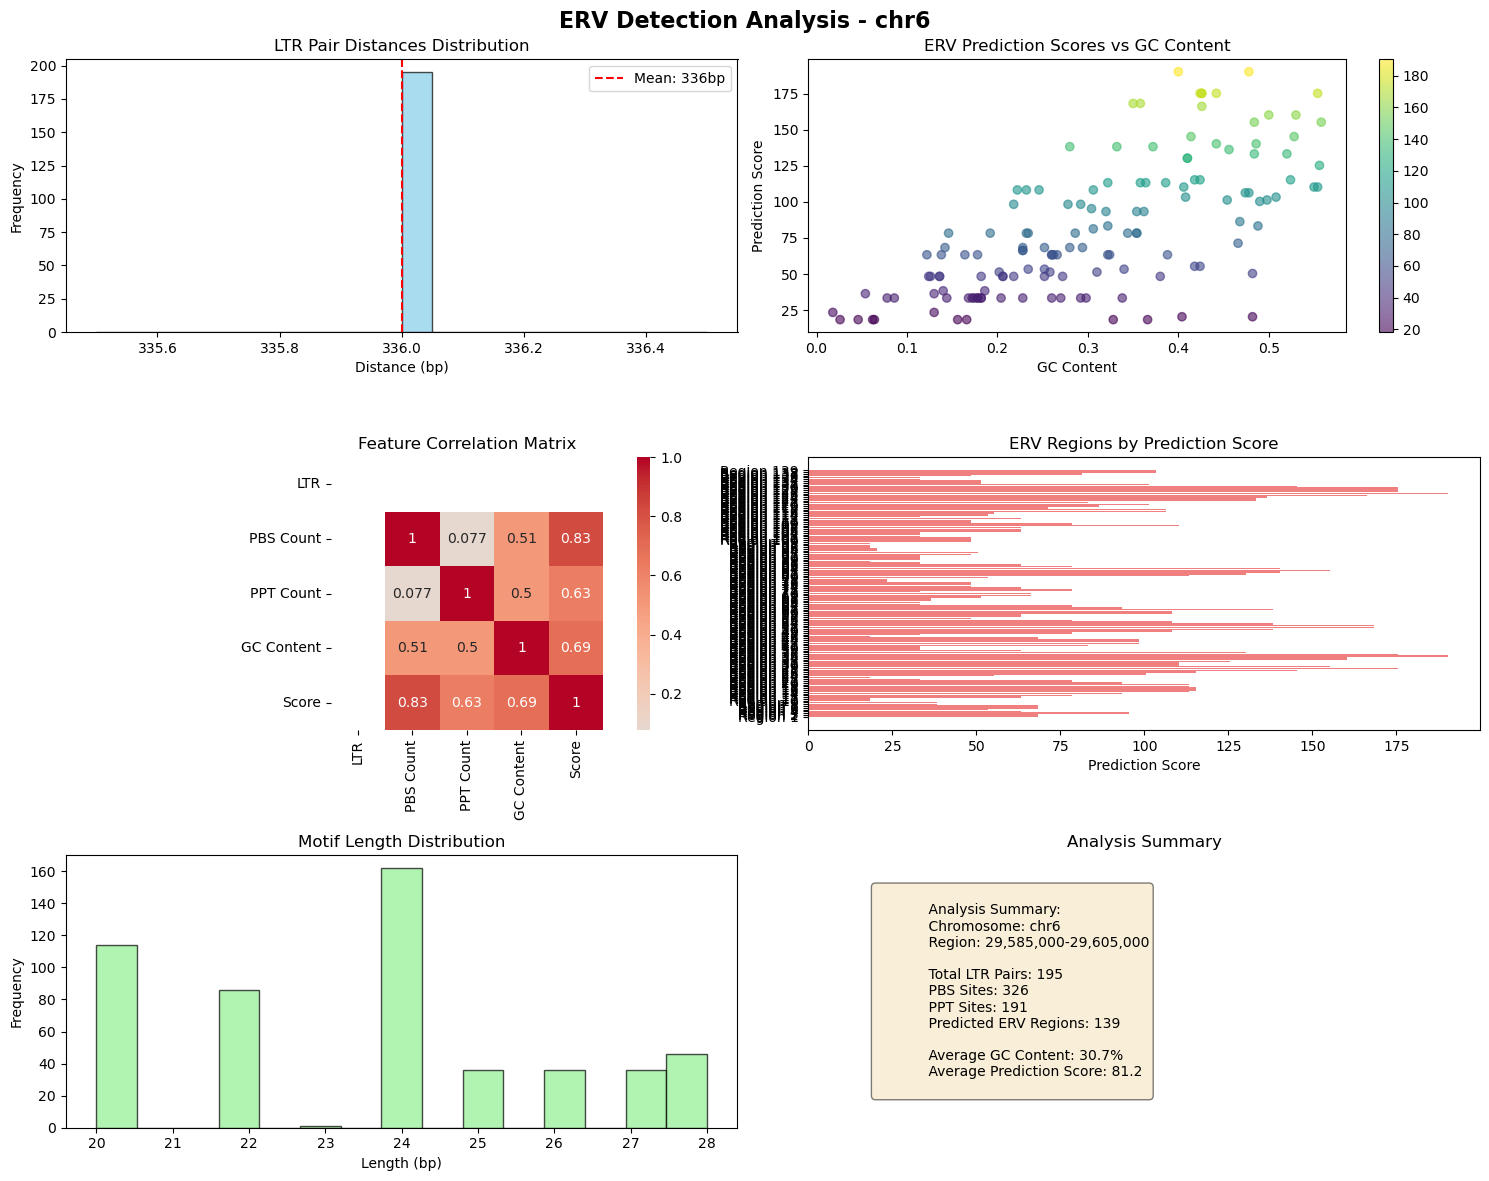

In [16]:

run_analysis()